# Analyse exploratoire 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import timeit

from scipy.spatial.distance import hamming
from sklearn.metrics import pairwise_distances
from Levenshtein import distance as lev

from biopandas.pdb import PandasPdb
from Bio.PDB import PDBParser
import nglview as nv

In [2]:
pd.set_option("display.max_columns", 30)

## Chargement des données

In [3]:
train = pd.read_csv("Data/train_correct.csv") 
test = pd.read_csv("Data/test.csv")

In [4]:
print("train shape : ", train.shape)
print("test shape : ", test.shape)

train shape :  (28981, 5)
test shape :  (2413, 4)


In [5]:
train.head()

,seq_id,protein_sequence,pH,data_source,tm
0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,doi.org/10.1038/s41592-020-0801-4,75.7
1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,doi.org/10.1038/s41592-020-0801-4,50.5
2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,doi.org/10.1038/s41592-020-0801-4,40.5
3,3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,doi.org/10.1038/s41592-020-0801-4,47.2
4,4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,doi.org/10.1038/s41592-020-0801-4,49.5


In [6]:
test.head()

,seq_id,protein_sequence,pH,data_source
0,31390,VPVNPEPDATSVENVAEKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
1,31391,VPVNPEPDATSVENVAKKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
2,31392,VPVNPEPDATSVENVAKTGSGDSQSDPIKADLEVKGQSALPFDVDC...,8,Novozymes
3,31393,VPVNPEPDATSVENVALCTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
4,31394,VPVNPEPDATSVENVALFTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes


## Nettoyage

Nous n'avons pas besoin des 'data_source'.

In [8]:
train.drop('data_source', axis=1, inplace=True)
test.drop('data_source', axis=1, inplace=True)

Il y a des doublons dans le fichier train. On les supprime. 

In [9]:
train.drop_duplicates(subset='protein_sequence', inplace=True)
train.shape

(27375, 4)

In [10]:
train.dropna(inplace=True)

## pH et tm

<AxesSubplot: xlabel='pH', ylabel='Count'>

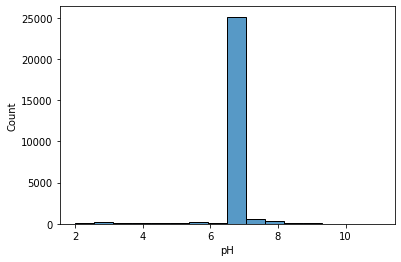

In [11]:
sns.histplot(data=train, x='pH')

<AxesSubplot: xlabel='tm', ylabel='Count'>

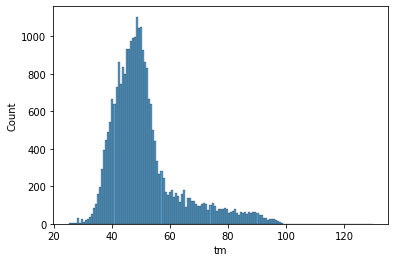

In [12]:
sns.histplot(data=train, x='tm')

In [13]:
test['pH'].value_counts()

8    2413
Name: pH, dtype: int64

## Séquences des protéines

### Longueur

In [14]:
train['protein_sequence'].iloc[0]

'AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVGMIKDAGDDPDVTHGAEIQAFVRFASEDRLEGGEGVGVVTKPGLGVPVGEPAINPVPRRMIWEAVREVTERPLAVTIAIPGGEELAKKTLNPRLGILGGLSVLGTTGVVKPYSTSAFRMSVVQAVGVARANGLLEIAATTGGKSERFAQRLLPHLPEMAFIEMGDFVGDVLRAARKVGVEVVRVVGMIGKISKMADGKTMTHAAGGEVNLSLLLSLLKEAGASPKALKEAEGAATARRFLEIALEEGLELFFVNLVRLAQEKLQAYIGERPFVSVALTDFDEGRCLAAWPDREVYR'

In [15]:
train['protein_length'] = train['protein_sequence'].apply(lambda x: len(x))

<AxesSubplot: xlabel='protein_length', ylabel='Count'>

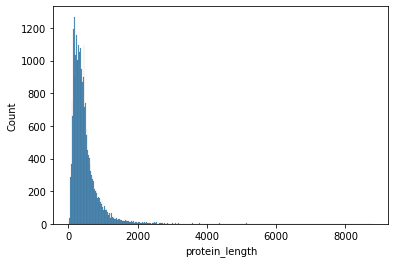

In [16]:
sns.histplot(data=train, x='protein_length')

In [17]:
train.describe()

,seq_id,pH,tm,protein_length
count,27117.000000,27117.000000,27117.000000,27117.000000
mean,15576.142383,6.942945,51.278759,466.183538
std,9363.488680,0.600389,12.051977,420.964977
min,0.000000,1.990000,25.100000,5.000000
25%,7248.000000,7.000000,43.600000,227.000000
50%,15093.000000,7.000000,48.700000,367.000000
75%,23940.000000,7.000000,54.200000,553.000000
max,31389.000000,11.000000,130.000000,8798.000000


In [18]:
test['protein_sequence'].apply(lambda x: len(x)).value_counts()

221    2336
220      77
Name: protein_sequence, dtype: int64

In [19]:
train = train[train['protein_length']<1000]
train.shape

(25177, 5)

<AxesSubplot: xlabel='protein_length', ylabel='Count'>

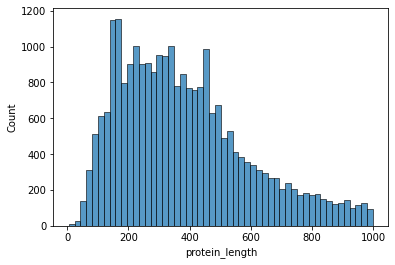

In [20]:
sns.histplot(data=train, x='protein_length')

### Le fichier pdb

In [21]:
pdb = PandasPdb().read_pdb("Data/wildtype_structure_prediction_af2.pdb")

In [22]:
type(pdb.df)

dict

In [23]:
pdb.df.keys()

dict_keys(['ATOM', 'HETATM', 'ANISOU', 'OTHERS'])

In [24]:
pdb.df['ATOM']

,record_name,atom_number,blank_1,atom_name,alt_loc,residue_name,blank_2,chain_id,residue_number,insertion,blank_3,x_coord,y_coord,z_coord,occupancy,b_factor,blank_4,segment_id,element_symbol,charge,line_idx
0,ATOM,1,,N,,VAL,,A,1,,,34.064,-6.456,50.464,1.0,45.11,,,N,NaN,0
1,ATOM,2,,H,,VAL,,A,1,,,33.576,-6.009,51.228,1.0,45.11,,,H,NaN,1
2,ATOM,3,,H2,,VAL,,A,1,,,33.882,-7.449,50.477,1.0,45.11,,,H,NaN,2
3,ATOM,4,,H3,,VAL,,A,1,,,35.060,-6.323,50.566,1.0,45.11,,,H,NaN,3
4,ATOM,5,,CA,,VAL,,A,1,,,33.643,-5.877,49.162,1.0,45.11,,,C,NaN,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3312,ATOM,3313,,NZ,,LYS,,A,221,,,4.616,13.323,-4.301,1.0,93.80,,,N,NaN,3312
3313,ATOM,3314,,HZ1,,LYS,,A,221,,,5.270,12.565,-4.432,1.0,93.80,,,H,NaN,3313
3314,ATOM,3315,,HZ2,,LYS,,A,221,,,4.585,13.517,-3.310,1.0,93.80,,,H,NaN,3314
3315,ATOM,3316,,HZ3,,LYS,,A,221,,,4.965,14.143,-4.776,1.0,93.80,,,H,NaN,3315


In [25]:
from Bio.PDB import PDBParser
import nglview as nv

In [26]:
pdb_parser = PDBParser()
structure = pdb_parser.get_structure("PHA-L","Data/wildtype_structure_prediction_af2.pdb")

In [27]:
view = nv.show_biopython(structure)
view

NGLWidget()

## Acides aminées

In [28]:
amino_count = train['protein_sequence'].str.split('').explode('protein_sequence').value_counts().drop('')
amino_count

L    910999
A    742560
E    688730
S    660799
G    660011
V    635510
K    597705
D    534103
I    528047
R    516243
T    500077
P    471037
N    401995
Q    398555
F    373084
Y    291839
M    228067
H    217438
C    135498
W    108771
Name: protein_sequence, dtype: int64

<AxesSubplot: ylabel='protein_sequence'>

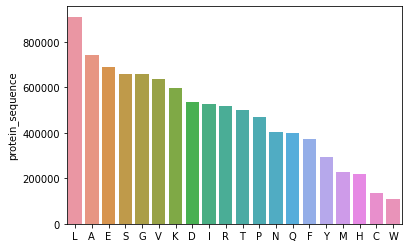

In [29]:
sns.barplot(x=amino_count.index, y=amino_count)

## Protéines et mutations

### test

In [30]:
test

,seq_id,protein_sequence,pH
0,31390,VPVNPEPDATSVENVAEKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8
1,31391,VPVNPEPDATSVENVAKKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8
2,31392,VPVNPEPDATSVENVAKTGSGDSQSDPIKADLEVKGQSALPFDVDC...,8
3,31393,VPVNPEPDATSVENVALCTGSGDSQSDPIKADLEVKGQSALPFDVD...,8
4,31394,VPVNPEPDATSVENVALFTGSGDSQSDPIKADLEVKGQSALPFDVD...,8
...,...,...,...
2408,33798,VPVNPEPDATSVENVILKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8
2409,33799,VPVNPEPDATSVENVLLKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8
2410,33800,VPVNPEPDATSVENVNLKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8
2411,33801,VPVNPEPDATSVENVPLKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8


#### Distance de Hamming

In [31]:
df = pd.DataFrame(test['protein_sequence'].apply(list).tolist())
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,...,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220
0,V,P,V,N,P,E,P,D,A,T,S,V,E,N,V,...,Y,Q,Y,D,E,K,N,N,K,F,N,Y,V,G,K
1,V,P,V,N,P,E,P,D,A,T,S,V,E,N,V,...,Y,Q,Y,D,E,K,N,N,K,F,N,Y,V,G,K
2,V,P,V,N,P,E,P,D,A,T,S,V,E,N,V,...,Q,Y,D,E,K,N,N,K,F,N,Y,V,G,K,None
3,V,P,V,N,P,E,P,D,A,T,S,V,E,N,V,...,Y,Q,Y,D,E,K,N,N,K,F,N,Y,V,G,K
4,V,P,V,N,P,E,P,D,A,T,S,V,E,N,V,...,Y,Q,Y,D,E,K,N,N,K,F,N,Y,V,G,K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2408,V,P,V,N,P,E,P,D,A,T,S,V,E,N,V,...,Y,Q,Y,D,E,K,N,N,K,F,N,Y,V,G,K
2409,V,P,V,N,P,E,P,D,A,T,S,V,E,N,V,...,Y,Q,Y,D,E,K,N,N,K,F,N,Y,V,G,K
2410,V,P,V,N,P,E,P,D,A,T,S,V,E,N,V,...,Y,Q,Y,D,E,K,N,N,K,F,N,Y,V,G,K
2411,V,P,V,N,P,E,P,D,A,T,S,V,E,N,V,...,Y,Q,Y,D,E,K,N,N,K,F,N,Y,V,G,K


In [32]:
amino_list = list(set(list(train['protein_sequence'].iloc[0])))
amino_list.sort()
len(amino_list)

20

In [33]:
amino_dict = {k: i+1 for i, k in enumerate(amino_list)}
amino_dict[None] = 0

In [34]:
df = df.replace(amino_dict)
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,...,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220
0,18,13,18,12,13,4,13,3,1,17,16,18,4,12,18,...,20,14,20,3,4,9,12,12,9,5,12,20,18,6,9.0
1,18,13,18,12,13,4,13,3,1,17,16,18,4,12,18,...,20,14,20,3,4,9,12,12,9,5,12,20,18,6,9.0
2,18,13,18,12,13,4,13,3,1,17,16,18,4,12,18,...,14,20,3,4,9,12,12,9,5,12,20,18,6,9,NaN
3,18,13,18,12,13,4,13,3,1,17,16,18,4,12,18,...,20,14,20,3,4,9,12,12,9,5,12,20,18,6,9.0
4,18,13,18,12,13,4,13,3,1,17,16,18,4,12,18,...,20,14,20,3,4,9,12,12,9,5,12,20,18,6,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2408,18,13,18,12,13,4,13,3,1,17,16,18,4,12,18,...,20,14,20,3,4,9,12,12,9,5,12,20,18,6,9.0
2409,18,13,18,12,13,4,13,3,1,17,16,18,4,12,18,...,20,14,20,3,4,9,12,12,9,5,12,20,18,6,9.0
2410,18,13,18,12,13,4,13,3,1,17,16,18,4,12,18,...,20,14,20,3,4,9,12,12,9,5,12,20,18,6,9.0
2411,18,13,18,12,13,4,13,3,1,17,16,18,4,12,18,...,20,14,20,3,4,9,12,12,9,5,12,20,18,6,9.0


In [35]:
df = df.fillna(0)
df = df.astype(int)

In [36]:
X = df.values
X

array([[18, 13, 18, ..., 18,  6,  9],
       [18, 13, 18, ..., 18,  6,  9],
       [18, 13, 18, ...,  6,  9,  0],
       ...,
       [18, 13, 18, ..., 18,  6,  9],
       [18, 13, 18, ..., 18,  6,  9],
       [18, 13, 18, ..., 18,  6,  9]])

In [37]:
start_time = timeit.default_timer()

hamming_test_matrix = pairwise_distances(X, metric=hamming)
    
temps = timeit.default_timer() - start_time
print(temps)

14.634599099999996


In [38]:
hamming_test_matrix

array([[0.        , 0.00452489, 0.89140271, ..., 0.00904977, 0.00904977,
        0.00904977],
       [0.00452489, 0.        , 0.88687783, ..., 0.00904977, 0.00904977,
        0.00904977],
       [0.89140271, 0.88687783, 0.        , ..., 0.8959276 , 0.8959276 ,
        0.8959276 ],
       ...,
       [0.00904977, 0.00904977, 0.8959276 , ..., 0.        , 0.00452489,
        0.00452489],
       [0.00904977, 0.00904977, 0.8959276 , ..., 0.00452489, 0.        ,
        0.00452489],
       [0.00904977, 0.00904977, 0.8959276 , ..., 0.00452489, 0.00452489,
        0.        ]])

#### Distance de Levenshtein

In [39]:
n = test.shape[0]

In [40]:
levenshtein_test_matrix = np.full((n, n), 0)

In [41]:
start_time = timeit.default_timer()
for i in range(n):
    for j in range(i+1, n):
        levenshtein_test_matrix[i][j] = lev(test['protein_sequence'].iloc[i], test['protein_sequence'].iloc[j])
temps = timeit.default_timer() - start_time
print(temps)

23.000602899999997


In [42]:
n*100*22.21/(60*60)

1488.6869444444444

In [43]:
levenshtein_test_matrix

array([[0, 1, 1, ..., 2, 2, 2],
       [0, 0, 1, ..., 2, 2, 2],
       [0, 0, 0, ..., 2, 2, 2],
       ...,
       [0, 0, 0, ..., 0, 1, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0]])

In [44]:
levenshtein_test_matrix.max()

2

In [45]:
levenshtein_test_matrix = levenshtein_test_matrix + levenshtein_test_matrix.T
levenshtein_test_matrix

array([[0, 1, 1, ..., 2, 2, 2],
       [1, 0, 1, ..., 2, 2, 2],
       [1, 1, 0, ..., 2, 2, 2],
       ...,
       [2, 2, 2, ..., 0, 1, 1],
       [2, 2, 2, ..., 1, 0, 1],
       [2, 2, 2, ..., 1, 1, 0]])

### train

In [46]:
def tronc_str(x, n):
    if len(x) < n:
        return x
    else:
        return x[:n]

In [47]:
train['first_20'] = train['protein_sequence'].apply(lambda x: tronc_str(x, 20))

In [48]:
train

,seq_id,protein_sequence,pH,tm,protein_length,first_20
0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,75.7,341,AAAAKAAALALLGEAPEVVD
1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,50.5,286,AAADGEPLHNEEERAGAGQV
2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,40.5,497,AAAFSTPRATSYRILSSAGS
3,3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,47.2,265,AAASGLRTAIPAQPLRHLLQ
5,5,AACFWRRTVIPKPPFRGISTTSARSTVMPAWVIDKYGKNEVLRFTQ...,7.0,48.4,380,AACFWRRTVIPKPPFRGIST
...,...,...,...,...,...,...
28976,31385,YYMYSGGGSALAAGGGGAGRKGDWNDIDSIKKKDLHHSRGDEKAQG...,7.0,51.8,549,YYMYSGGGSALAAGGGGAGR
28977,31386,YYNDQHRLSSYSVETAMFLSWERAIVKPGAMFKKAVIGFNCNVDLI...,7.0,37.2,469,YYNDQHRLSSYSVETAMFLS
28978,31387,YYQRTLGAELLYKISFGEMPKSAQDSAENCPSGMQFPDTAIAHANV...,7.0,64.6,128,YYQRTLGAELLYKISFGEMP
28979,31388,YYSFSDNITTVFLSRQAIDDDHSLSLGTISDVVESENGVVAADDAR...,7.0,50.7,593,YYSFSDNITTVFLSRQAIDD


In [49]:
copy_train = train.copy()

In [50]:
def time_to_compute(n):
    dic = {}
    n_group = 1
    start_time = timeit.default_timer()
    for j in range(n) :
        l = []
        a = copy_train['first_20'].iloc[0]
        for i in copy_train.index:
            if lev(a, copy_train['first_20'].loc[i])<= 3:
                l.append(i)
        dic[n_group] = l
        n_group += 1
        copy_train.drop(l, axis=0, inplace=True)

    temps = timeit.default_timer() - start_time
    return temps

In [51]:
time_to_compute(10)

1.4370211000000026

In [52]:
copy_train = train.copy()
time_to_compute(100)

14.2917652

In [53]:
copy_train = train.copy()
temps = time_to_compute(1000)
temps

140.274929

In [54]:
temps*25/60

58.44788708333333

In [55]:
# le vrai code
copy_train = train.copy()
dic = {}
n_group = 1
start_time = timeit.default_timer()
while copy_train.shape[0] > 0 :
    l = []
    a = copy_train['first_20'].iloc[0]
    for i in copy_train.index:
        if lev(a, copy_train['first_20'].loc[i])<= 3:
            l.append(i)
    dic[n_group] = l
    n_group += 1
    copy_train.drop(l, axis=0, inplace=True)
    
temps = timeit.default_timer() - start_time
print(temps)

2298.7404892000004


In [69]:
temps/60

38.312341486666675

In [ ]:
# --------------------------------
#pour éviter de relancer la ligne précédente

In [56]:
liste = [dic[i] for i in dic.keys()]
d = {'col1': liste}
groupes = pd.DataFrame(data=d, index=dic.keys())
groupes

,col1
1,[0]
2,[1]
3,[2]
4,[3]
5,"[5, 6]"
...,...
21789,[28976]
21790,[28977]
21791,[28978]
21792,[28979]


In [57]:
groupes.to_csv('Data/groupes_train.csv', index = False)

In [51]:
groupes = pd.read_csv("Data/groupes_train.csv")

In [59]:
groupes

,col1
0,[0]
1,[1]
2,[2]
3,[3]
4,"[4, 5]"
...,...
21787,[25171]
21788,[25172]
21789,[25173]
21790,[25174]


In [52]:
groupes['col1'] = groupes['col1'].apply(lambda x: eval(x))

In [58]:
train['groupe'] = np.nan

In [59]:
for i in range(groupes.shape[0]):
    for j in groupes['col1'].values[i]:
        train['groupe'].loc[j] = i

C:\Users\tony.mathieux\AppData\Local\Temp\ipykernel_7116\778510808.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['groupe'].loc[j] = i


In [60]:
train['groupe'].iloc[train.shape[0]-1] = 21792

C:\Users\tony.mathieux\AppData\Local\Temp\ipykernel_7116\1110563190.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['groupe'].iloc[train.shape[0]-1] = 21792


In [61]:
train

,seq_id,protein_sequence,pH,tm,protein_length,first_20,groupe
0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,75.7,341,AAAAKAAALALLGEAPEVVD,0.0
1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,50.5,286,AAADGEPLHNEEERAGAGQV,1.0
2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,40.5,497,AAAFSTPRATSYRILSSAGS,2.0
3,3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,47.2,265,AAASGLRTAIPAQPLRHLLQ,3.0
5,5,AACFWRRTVIPKPPFRGISTTSARSTVMPAWVIDKYGKNEVLRFTQ...,7.0,48.4,380,AACFWRRTVIPKPPFRGIST,4.0
...,...,...,...,...,...,...,...
28976,31385,YYMYSGGGSALAAGGGGAGRKGDWNDIDSIKKKDLHHSRGDEKAQG...,7.0,51.8,549,YYMYSGGGSALAAGGGGAGR,21788.0
28977,31386,YYNDQHRLSSYSVETAMFLSWERAIVKPGAMFKKAVIGFNCNVDLI...,7.0,37.2,469,YYNDQHRLSSYSVETAMFLS,21789.0
28978,31387,YYQRTLGAELLYKISFGEMPKSAQDSAENCPSGMQFPDTAIAHANV...,7.0,64.6,128,YYQRTLGAELLYKISFGEMP,21790.0
28979,31388,YYSFSDNITTVFLSRQAIDDDHSLSLGTISDVVESENGVVAADDAR...,7.0,50.7,593,YYSFSDNITTVFLSRQAIDD,21791.0


In [62]:
train['groupe'] = train['groupe'].astype('int')
train

,seq_id,protein_sequence,pH,tm,protein_length,first_20,groupe
0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,75.7,341,AAAAKAAALALLGEAPEVVD,0
1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,50.5,286,AAADGEPLHNEEERAGAGQV,1
2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,40.5,497,AAAFSTPRATSYRILSSAGS,2
3,3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,47.2,265,AAASGLRTAIPAQPLRHLLQ,3
5,5,AACFWRRTVIPKPPFRGISTTSARSTVMPAWVIDKYGKNEVLRFTQ...,7.0,48.4,380,AACFWRRTVIPKPPFRGIST,4
...,...,...,...,...,...,...,...
28976,31385,YYMYSGGGSALAAGGGGAGRKGDWNDIDSIKKKDLHHSRGDEKAQG...,7.0,51.8,549,YYMYSGGGSALAAGGGGAGR,21788
28977,31386,YYNDQHRLSSYSVETAMFLSWERAIVKPGAMFKKAVIGFNCNVDLI...,7.0,37.2,469,YYNDQHRLSSYSVETAMFLS,21789
28978,31387,YYQRTLGAELLYKISFGEMPKSAQDSAENCPSGMQFPDTAIAHANV...,7.0,64.6,128,YYQRTLGAELLYKISFGEMP,21790
28979,31388,YYSFSDNITTVFLSRQAIDDDHSLSLGTISDVVESENGVVAADDAR...,7.0,50.7,593,YYSFSDNITTVFLSRQAIDD,21791


In [ ]:
# ----------------------------------
# fin

## Les groupes de mutation de train

In [70]:
group_train = train.groupby(['groupe'])
group_train = group_train.agg({
    'seq_id': 'count',
    'pH': 'mean',
    'tm': 'mean'
})

In [71]:
group_train

,seq_id,pH,tm
groupe,,,
0,1,7.0,75.70
1,1,7.0,50.50
2,1,7.0,40.50
3,1,7.0,47.20
4,2,7.0,47.05
...,...,...,...
21788,1,7.0,51.80
21789,1,7.0,37.20
21790,1,7.0,64.60


In [73]:
group_train['seq_id'].value_counts()

1      20925
2        679
3         69
4         32
5         12
6          8
8          6
10         6
14         4
7          4
9          4
12         3
15         3
37         3
25         3
32         2
27         2
74         2
78         1
211        1
19         1
28         1
26         1
21         1
56         1
48         1
52         1
46         1
292        1
16         1
34         1
143        1
31         1
45         1
17         1
84         1
122        1
50         1
38         1
62         1
57         1
35         1
49         1
30         1
Name: seq_id, dtype: int64

In [74]:
group_train = group_train[group_train['seq_id'] > 100]
group_train

,seq_id,pH,tm
groupe,,,
10195,122,2.756557,61.601639
12181,143,6.921538,47.646853
12462,292,4.108938,51.886644
13004,211,8.000000,61.988626


In [75]:
train[train['groupe'] == 12462]

,seq_id,protein_sequence,pH,tm,protein_length,first_20,groupe
16160,18020,MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,2.0,38.1,164,MNAFEMLRIDERLRLKIYKD,12462
16200,18060,MNCFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,2.0,41.9,164,MNCFEMLRIDERLRLKIYKD,12462
16211,18071,MNDFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,4.2,53.3,164,MNDFEMLRIDERLRLKIYKD,12462
16252,18112,MNEFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,2.0,37.8,164,MNEFEMLRIDERLRLKIYKD,12462
16311,18171,MNFFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,2.0,34.1,164,MNFFEMLRIDERLRLKIYKD,12462
...,...,...,...,...,...,...,...
17785,19771,MNSFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,2.0,34.9,164,MNSFEMLRIDERLRLKIYKD,12462
17861,19847,MNTFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,3.0,49.2,164,MNTFEMLRIDERLRLKIYKD,12462
17909,19899,MNVFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,2.0,39.8,164,MNVFEMLRIDERLRLKIYKD,12462
17957,19949,MNWFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,6.5,56.7,164,MNWFEMLRIDERLRLKIYKD,12462


In [76]:
train[train['groupe'] == 13004]

,seq_id,protein_sequence,pH,tm,protein_length,first_20,groupe
17494,19480,MNQSVKSLPEKDIQYQLHPYTNARLHQELGPLIIERGEGIYVYDDQ...,8.0,62.5,455,MNQSVKSLPEKDIQYQLHPY,13004
17495,19481,MNQSVSSLAEKDIQYQLHPYTNARLHQELGPLIIERGEGIYVYDDQ...,8.0,64.0,455,MNQSVSSLAEKDIQYQLHPY,13004
17496,19482,MNQSVSSLKEKDIQYQLHPYTNARLHQELGPLIIERGEGIYVYDDQ...,8.0,63.5,455,MNQSVSSLKEKDIQYQLHPY,13004
17497,19483,MNQSVSSLPEKDIQYQLHPYTDARLHQELGPLIIERGEGIYVYDDQ...,8.0,62.0,455,MNQSVSSLPEKDIQYQLHPY,13004
17498,19484,MNQSVSSLPEKDIQYQLHPYTEARLHQELGPLIIERGEGIYVYDDQ...,8.0,61.5,455,MNQSVSSLPEKDIQYQLHPY,13004
...,...,...,...,...,...,...,...
17700,19686,MNQSVSSLPEKDIQYQLHPYTNARLHQKLGPLIIERGEGIYVYDDQ...,8.0,62.5,455,MNQSVSSLPEKDIQYQLHPY,13004
17701,19687,MNQSVSSLPEKDIQYQLHPYTNARLMQELGPLIIERGEGIYVYDDQ...,8.0,62.0,455,MNQSVSSLPEKDIQYQLHPY,13004
17702,19688,MNQSVSSLPEKDIQYQLHPYTNLRLHQELGPLIIERGEGIYVYDDQ...,8.0,62.0,455,MNQSVSSLPEKDIQYQLHPY,13004
17703,19689,MNQSVSSLPEKDKQYQLHPYTNARLHQELGPLIIERGEGIYVYDDQ...,8.0,62.0,455,MNQSVSSLPEKDKQYQLHPY,13004


In [77]:
list_100 = list(group_train.index)
list_100

[10195, 12181, 12462, 13004]

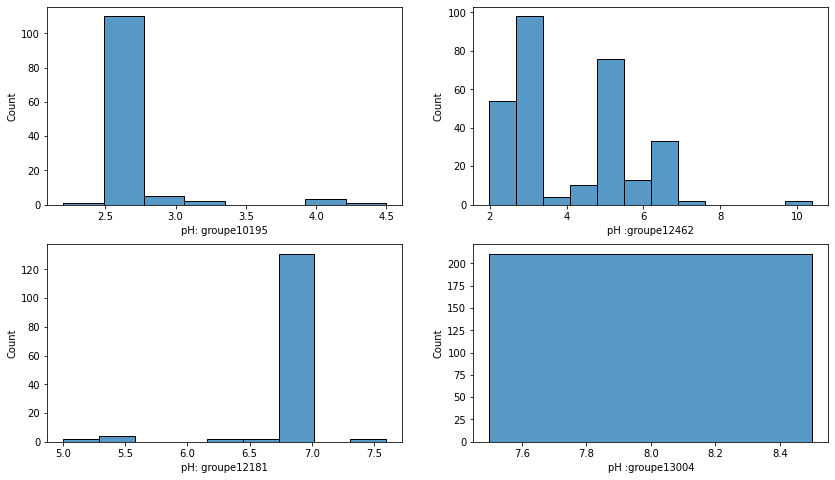

In [80]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))

for i in range(2):
    sns.histplot(data=train[train['groupe'] == list_100[i]], x='pH', ax=axs[i, 0]).set(xlabel='pH: groupe ' + str(list_100[i]))

for i in range(2): 
    sns.histplot(data=train[train['groupe'] == list_100[i+2]], x='pH', ax=axs[i, 1]).set(xlabel='pH :groupe ' + str(list_100[i+2]))

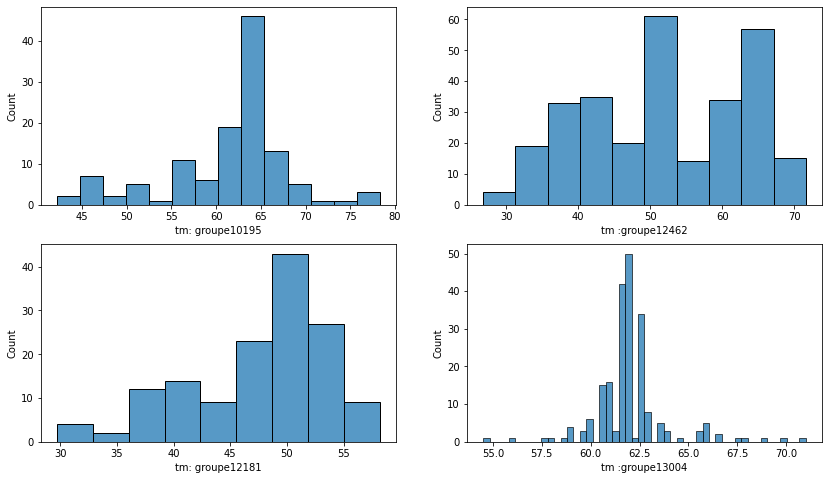

In [82]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))

for i in range(2):
    sns.histplot(data=train[train['groupe'] == list_100[i]], x='tm', ax=axs[i, 0]).set(xlabel='tm: groupe ' + str(list_100[i]))

for i in range(2):
    sns.histplot(data=train[train['groupe'] == list_100[i+2]], x='tm', ax=axs[i, 1]).set(xlabel='tm :groupe ' + str(list_100[i+2]))

In [84]:
meanprops = {'marker':'o', 'markeredgecolor':'black', 'markerfacecolor':'firebrick'}
# Un point rouge indiquera la moyenne dans les boxplot

<AxesSubplot: xlabel='tm', ylabel='groupe'>

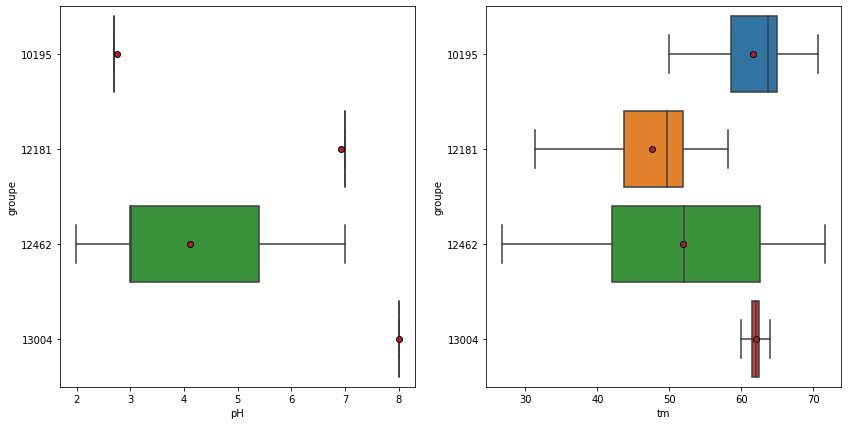

In [90]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

sns.boxplot(x="pH", y="groupe", showfliers=False, showmeans=True, meanprops=meanprops,
            orient='h', data=train[train['groupe'].isin(list_100)], ax=axs[0])
sns.boxplot(x="tm", y="groupe", showfliers=False, showmeans=True, meanprops=meanprops,
            orient='h', data=train[train['groupe'].isin(list_100)], ax=axs[1])

## Ajout de variables

### Première approche

In [63]:
train1 = train.copy()
train1

,seq_id,protein_sequence,pH,tm,protein_length,first_20,groupe
0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,75.7,341,AAAAKAAALALLGEAPEVVD,0
1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,50.5,286,AAADGEPLHNEEERAGAGQV,1
2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,40.5,497,AAAFSTPRATSYRILSSAGS,2
3,3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,47.2,265,AAASGLRTAIPAQPLRHLLQ,3
5,5,AACFWRRTVIPKPPFRGISTTSARSTVMPAWVIDKYGKNEVLRFTQ...,7.0,48.4,380,AACFWRRTVIPKPPFRGIST,4
...,...,...,...,...,...,...,...
28976,31385,YYMYSGGGSALAAGGGGAGRKGDWNDIDSIKKKDLHHSRGDEKAQG...,7.0,51.8,549,YYMYSGGGSALAAGGGGAGR,21788
28977,31386,YYNDQHRLSSYSVETAMFLSWERAIVKPGAMFKKAVIGFNCNVDLI...,7.0,37.2,469,YYNDQHRLSSYSVETAMFLS,21789
28978,31387,YYQRTLGAELLYKISFGEMPKSAQDSAENCPSGMQFPDTAIAHANV...,7.0,64.6,128,YYQRTLGAELLYKISFGEMP,21790
28979,31388,YYSFSDNITTVFLSRQAIDDDHSLSLGTISDVVESENGVVAADDAR...,7.0,50.7,593,YYSFSDNITTVFLSRQAIDD,21791


In [64]:
train1.drop('first_20', axis=1, inplace=True)

In [65]:
def count_amino(prot, am):
    count = len([l for l in prot if l==am])
    return count

In [66]:
for amino in amino_list:
    train1[amino] = train1['protein_sequence'].apply(lambda x: count_amino(x, amino))

In [67]:
train1

,seq_id,protein_sequence,pH,tm,protein_length,groupe,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,75.7,341,0,45,1,13,30,13,38,3,14,16,37,8,5,18,6,25,11,14,37,4,3
1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,50.5,286,1,28,0,10,52,6,18,4,13,19,23,2,6,8,22,30,14,12,13,3,3
2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,40.5,497,2,50,9,27,32,21,65,11,16,39,18,6,15,20,25,31,33,30,30,3,16
3,3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,47.2,265,3,20,5,19,29,12,16,7,10,17,28,2,9,16,9,10,16,19,14,3,4
5,5,AACFWRRTVIPKPPFRGISTTSARSTVMPAWVIDKYGKNEVLRFTQ...,7.0,48.4,380,4,33,4,16,19,16,33,9,16,27,33,11,13,19,8,16,22,25,41,10,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28976,31385,YYMYSGGGSALAAGGGGAGRKGDWNDIDSIKKKDLHHSRGDEKAQG...,7.0,51.8,549,21788,33,12,38,31,18,51,15,21,32,46,13,24,25,24,42,33,18,42,13,18
28977,31386,YYNDQHRLSSYSVETAMFLSWERAIVKPGAMFKKAVIGFNCNVDLI...,7.0,37.2,469,21789,37,5,21,29,22,27,22,30,20,47,14,19,19,16,25,37,26,34,5,14
28978,31387,YYQRTLGAELLYKISFGEMPKSAQDSAENCPSGMQFPDTAIAHANV...,7.0,64.6,128,21790,13,1,7,7,7,11,2,6,8,6,7,5,6,8,3,10,6,7,4,4
28979,31388,YYSFSDNITTVFLSRQAIDDDHSLSLGTISDVVESENGVVAADDAR...,7.0,50.7,593,21791,47,5,34,36,23,52,11,34,35,45,26,25,31,12,25,51,32,48,3,18


In [68]:
train1.to_csv('Data/train_version1_for_modelisation.csv', index=False)

### Deuxième approche

In [91]:
train2 = pd.DataFrame(train['protein_sequence'].apply(list).tolist())
train2

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,...,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998
0,A,A,A,A,K,A,A,A,L,A,L,L,G,E,A,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,A,A,A,D,G,E,P,L,H,N,E,E,E,R,A,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2,A,A,A,F,S,T,P,R,A,T,S,Y,R,I,L,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
3,A,A,A,S,G,L,R,T,A,I,P,A,Q,P,L,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4,A,A,C,F,W,R,R,T,V,I,P,K,P,P,F,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25172,Y,Y,M,Y,S,G,G,G,S,A,L,A,A,G,G,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
25173,Y,Y,N,D,Q,H,R,L,S,S,Y,S,V,E,T,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
25174,Y,Y,Q,R,T,L,G,A,E,L,L,Y,K,I,S,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
25175,Y,Y,S,F,S,D,N,I,T,T,V,F,L,S,R,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


In [92]:
train2 = train2.replace(amino_dict)
train2

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,...,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998
0,1,1,1,1,9,1.0,1.0,1.0,10.0,1.0,10.0,10.0,6.0,4.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,1,3,6,4.0,13.0,10.0,7.0,12.0,4.0,4.0,4.0,15.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,1,1,5,16,17.0,13.0,15.0,1.0,17.0,16.0,20.0,15.0,8.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,1,1,16,6,10.0,15.0,17.0,1.0,8.0,13.0,1.0,14.0,13.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,1,2,5,19,15.0,15.0,17.0,18.0,8.0,13.0,9.0,13.0,13.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25172,20,20,11,20,16,6.0,6.0,6.0,16.0,1.0,10.0,1.0,1.0,6.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25173,20,20,12,3,14,7.0,15.0,10.0,16.0,16.0,20.0,16.0,18.0,4.0,17.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25174,20,20,14,15,17,10.0,6.0,1.0,4.0,10.0,10.0,20.0,9.0,8.0,16.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25175,20,20,16,5,16,3.0,12.0,8.0,17.0,17.0,18.0,5.0,10.0,16.0,15.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [94]:
train2.fillna(0, inplace=True)
train2 = train2.astype('int')
train2

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,...,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998
0,1,1,1,1,9,1,1,1,10,1,10,10,6,4,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,1,3,6,4,13,10,7,12,4,4,4,15,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,1,1,5,16,17,13,15,1,17,16,20,15,8,10,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,1,1,16,6,10,15,17,1,8,13,1,14,13,10,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,1,2,5,19,15,15,17,18,8,13,9,13,13,5,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25172,20,20,11,20,16,6,6,6,16,1,10,1,1,6,6,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
25173,20,20,12,3,14,7,15,10,16,16,20,16,18,4,17,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
25174,20,20,14,15,17,10,6,1,4,10,10,20,9,8,16,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
25175,20,20,16,5,16,3,12,8,17,17,18,5,10,16,15,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [95]:
train2 = pd.concat([train2, train.reset_index()['pH']], axis=1)

In [96]:
train2

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,...,985,986,987,988,989,990,991,992,993,994,995,996,997,998,pH
0,1,1,1,1,9,1,1,1,10,1,10,10,6,4,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7.0
1,1,1,1,3,6,4,13,10,7,12,4,4,4,15,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7.0
2,1,1,1,5,16,17,13,15,1,17,16,20,15,8,10,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7.0
3,1,1,1,16,6,10,15,17,1,8,13,1,14,13,10,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7.0
4,1,1,2,5,19,15,15,17,18,8,13,9,13,13,5,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25172,20,20,11,20,16,6,6,6,16,1,10,1,1,6,6,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7.0
25173,20,20,12,3,14,7,15,10,16,16,20,16,18,4,17,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7.0
25174,20,20,14,15,17,10,6,1,4,10,10,20,9,8,16,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7.0
25175,20,20,16,5,16,3,12,8,17,17,18,5,10,16,15,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7.0


In [97]:
train2.to_csv('Data/train_version2_for_modelisation.csv', index=False)